# 04 Interpretabilidad de Modelos

En esta sección se busca entender **como** y **por que** los modelos toman sus decisiones.  
Ya contamos con varios modelos entrenados, evaluados y comparados previamente, así que ahora el objetivo es analizar su **comportamiento interno** y verificar si sus predicciones son **coherentes y justas**.

## 3.1. Interpretabilidad Global

### Selección del mejor modelo para el análisis de interpretabilidad

Al desarrollar los cuatro modelos, se hizo la siguiente tabla comparativa para evaluar sus principales métricas de desempeno:  

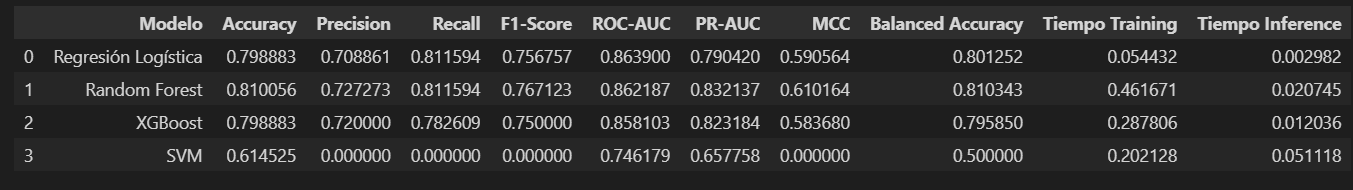

Al observar los resultados con mayor detalle, se puede ver que **Random Forest** presenta un **ligero mejor desempeño** en comparación con **Regresión Logística** y **XGBoost**, principalmente debido a sus valores superiores en métricas clave como **Accuracy** (0.81), **F1-Score** (0.767) y **PR-AUC** (0.832). Además, mantiene un buen equilibrio entre **Recall** y **Precision**, lo que lo hace más robusto en general.  

Por otro lado, el modelo **SVM** fue el de menor desempeño, con métricas significativamente más bajas en **Recall**, **Precision** y **F1-Score**, por lo que se descarta para los análisis posteriores.  

Con base en esto, utilizaremos **Random Forest** para realizar el **análisis de interpretabilidad** mediante **SHAP values**, con el objetivo de identificar las **features más importantes** y entender cómo influyen en las predicciones del modelo.


SHAP Analysis Global



Cargar datos y modelo

In [1]:
# Cargar datos
import pandas as pd
df = pd.read_csv('../data/processed.csv')
df_num = df.select_dtypes(include=['int64', 'float64'])
X = df_num.drop(columns='Survived')
y = df_num['Survived']

# Separar variables predictoras y target 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

# Cargar modelo entrenado 
import joblib
rf_model = joblib.load("../models/RandomForest_final.pkl")
print(rf_model.feature_names_in_)


['Pclass' 'Age' 'SibSp' 'Fare' 'FamilySize' 'IsAlone' 'FarePerPerson'
 'CabinKnown' 'TicketFrequency' 'NameLength' 'Pclass_1' 'Pclass_2'
 'Pclass_3' 'Sex_female' 'Sex_male' 'Embarked_C' 'Embarked_O' 'Embarked_Q'
 'Embarked_S' 'TitleGroup_Common' 'TitleGroup_Military' 'TitleGroup_Noble'
 'TitleGroup_Professional' 'AgeGroup_Niño' 'AgeGroup_Adolescente'
 'AgeGroup_Adulto Joven' 'AgeGroup_Adulto' 'AgeGroup_Mayor'
 'FareLevel_Muy bajo' 'FareLevel_Bajo' 'FareLevel_Medio' 'FareLevel_Alto'
 'FareLevel_Muy alto' 'Deck_A' 'Deck_B' 'Deck_C' 'Deck_D' 'Deck_E'
 'Deck_F' 'Deck_G' 'Deck_T' 'AgeGroup_LE' 'AgeGroup_ordinal'
 'FareLevel_ordinal']


SHAP summary plot (beeswarm)

In [6]:
#%pip install --upgrade numba

c:\Users\ivanl\OneDrive\Documentos\dataFootIL\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


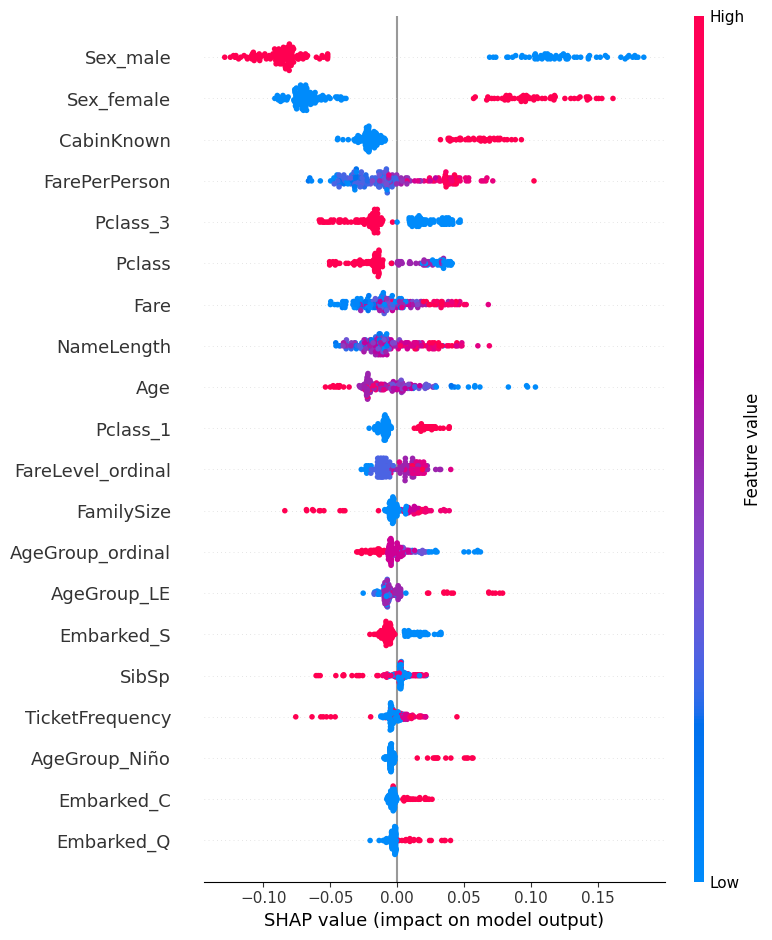

In [5]:
#%pip install shap
import shap

# Alinear features usadas en el entrenamiento
model_features = pd.Index(rf_model.feature_names_in_)
X = df[model_features].copy()
X_test_aligned = X_test.reindex(columns=model_features, fill_value=0)

# Calcular SHAP values
explainer = shap.TreeExplainer(rf_model)
sv = explainer.shap_values(X_test_aligned)

# Ajustar shape
cls_pos = list(rf_model.classes_).index(1)
sv_pos = sv[cls_pos] if isinstance(sv, list) else sv[..., cls_pos]
if sv_pos.shape[1] == X_test_aligned.shape[1] + 1:
    sv_pos = sv_pos[:, :-1]

# Grafica Beeswarm
shap.summary_plot(sv_pos,X_test_aligned,plot_type="dot")

SHAP feature importance (bar plot)

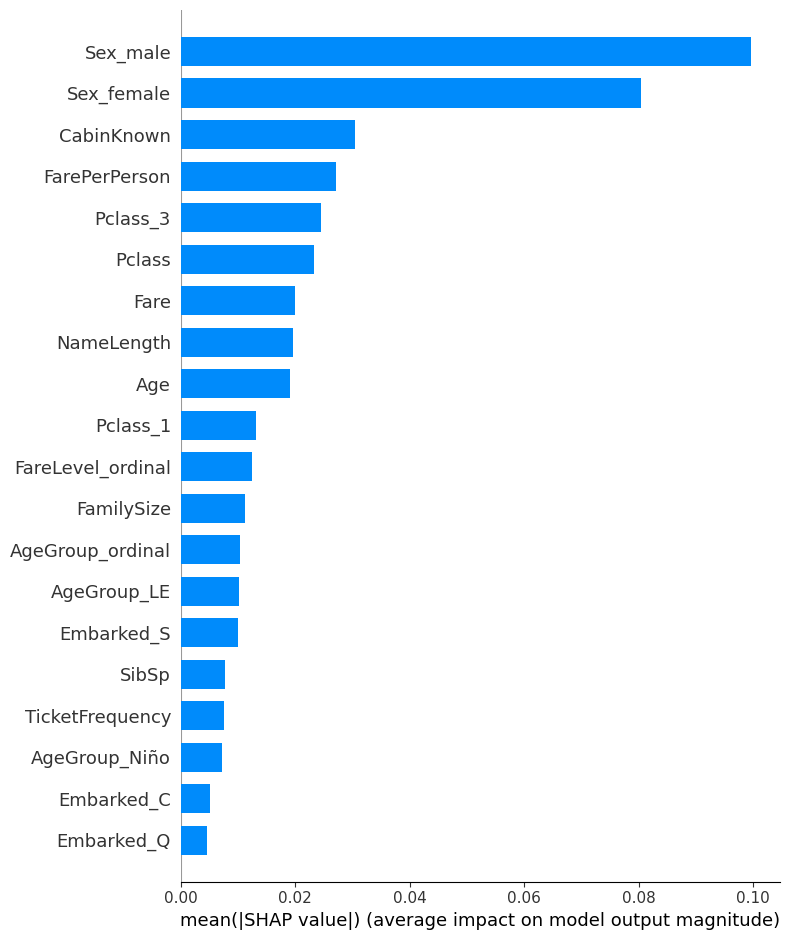

In [7]:
# Grafica SHAP Feature Importance (Bar Plot)
shap.summary_plot(sv_pos,X_test_aligned,plot_type="bar")

SHAP dependence plots para top features

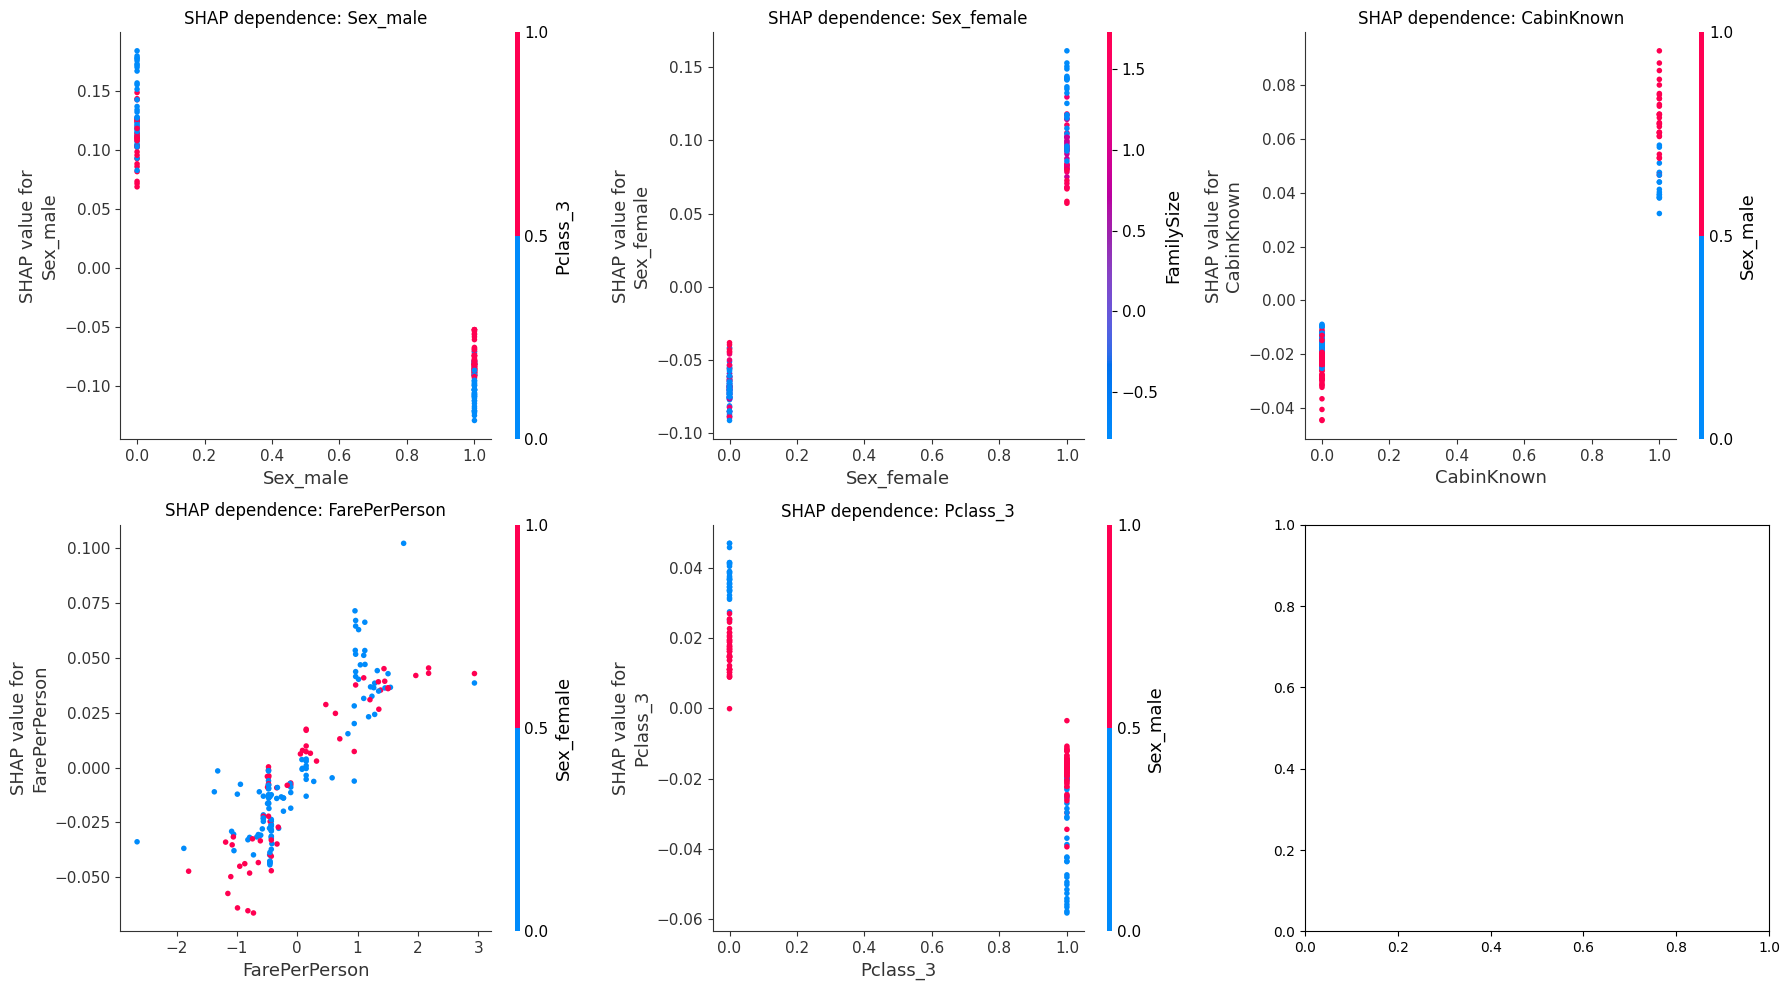

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Extraer media del SHAP por feature
imp = np.mean(np.abs(sv_pos), axis=0)                 
feature_names = X_test_aligned.columns.to_list()

# Obtener las 5 primeras features 
order = np.argsort(imp)[::-1]
top5_idx = order[:5]
top5_features = [feature_names[i] for i in top5_idx]

# Generar dependence plots para las 5 features mas relevantes
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  
axes = axes.flatten()

for i, f in enumerate(top5_features):
    shap.dependence_plot(f, sv_pos, X_test_aligned, interaction_index="auto",ax=axes[i], show=False)
    axes[i].set_title(f"SHAP dependence: {f}", fontsize=12)
plt.tight_layout()
plt.show()

SHAP interaction values

In [9]:
# Features mas relevantes
top5_features = [f for f in top5_features if f in X_test_aligned.columns]
feat2idx = {f: i for i, f in enumerate(X_test_aligned.columns)}
idx = [feat2idx[f] for f in top5_features]

# Obtener SHAP interaction values
inter = explainer.shap_interaction_values(X_test_aligned)
if isinstance(inter, list):  
    inter = inter[list(rf_model.classes_).index(1)]  

# Crear submatriz para las interacciones 
subM = np.abs(inter).mean(axis=0)  
if subM.ndim == 3:  # ajustar a una matriz 2D para evitar errores               
    subM = subM.mean(axis=2)

subM = subM[np.ix_(idx, idx)]
df_inter_top5 = pd.DataFrame(data=subM,index=top5_features,columns=top5_features)
df_inter_top5

,Sex_male,Sex_female,CabinKnown,FarePerPerson,Pclass_3
Sex_male,0.107188,0.000000,0.002906,0.003066,0.006385
Sex_female,0.000000,0.086191,0.002411,0.002424,0.003239
CabinKnown,0.002906,0.002411,0.035097,0.001467,0.000736
FarePerPerson,0.003066,0.002424,0.001467,0.027724,0.001094
Pclass_3,0.006385,0.003239,0.000736,0.001094,0.028270


SHAP force plot para casos promedio

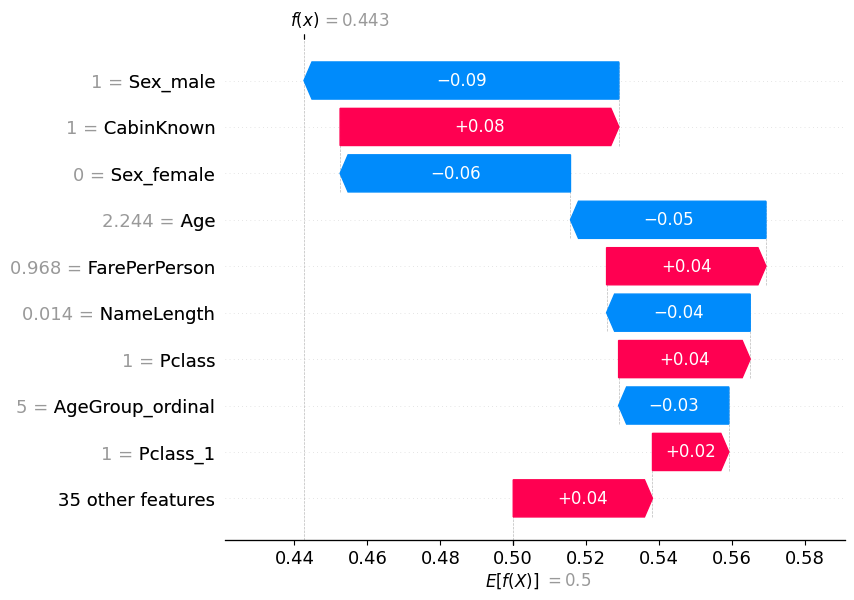

In [10]:
# Obtener SHAP values del modelo 
sv = explainer.shap_values(X_test_aligned)
if isinstance(sv, list):
    sv = sv[1]

# Calculo de las probabilidades y busqueda de un caso promedio
probs = rf_model.predict_proba(X_test_aligned)[:, 1]
idx = int(np.argmin(np.abs(probs - probs.mean())))  

# Usar el caso promedio 
values = sv[idx]
if values.ndim > 1:  
    values = values[:, 1]

# Creamos la explicacion para ese caso
exp = shap.Explanation(values=values,
base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
    data=X_test_aligned.iloc[idx],
    feature_names=X_test_aligned.columns.tolist())

# Caso promedio visualizado en el waterfall
shap.plots.waterfall(exp)

PDP individuales para las top 5 features

c:\Users\ivanl\OneDrive\Documentos\dataFootIL\.conda\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 14 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\ivanl\OneDrive\Documentos\dataFootIL\.conda\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 13 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\ivanl\OneDrive\Documentos

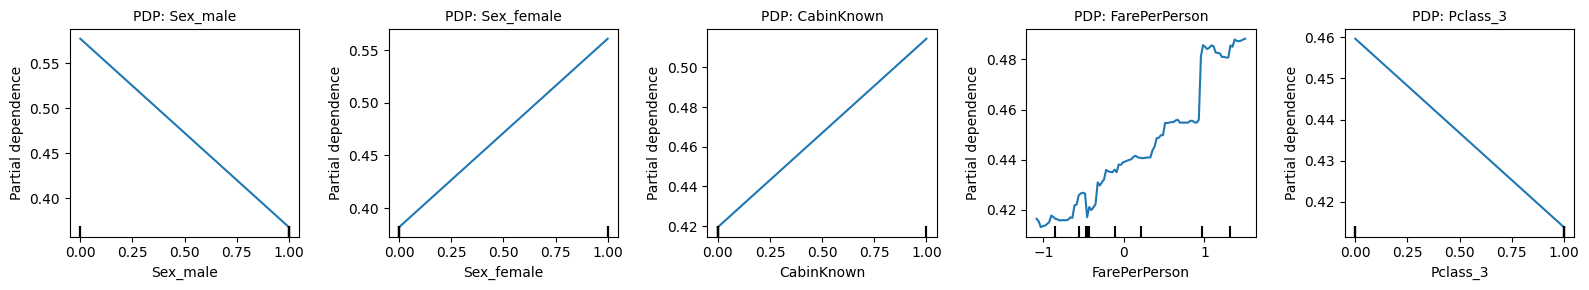

In [11]:
from sklearn.inspection import PartialDependenceDisplay

# Grafica de los PDP invidiuales de las 5 features
fig, axes = plt.subplots(1, len(top5_features), figsize=(16,3))
for i, f in enumerate(top5_features):
    PartialDependenceDisplay.from_estimator(rf_model,X_test_aligned,features=[f],kind="average",  ax=axes[i])
    axes[i].set_title(f"PDP: {f}", fontsize=10)
plt.tight_layout()
plt.show()

PDPs de interacciones (2D)

c:\Users\ivanl\OneDrive\Documentos\dataFootIL\.conda\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 14 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\ivanl\OneDrive\Documentos\dataFootIL\.conda\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 14 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\ivanl\OneDrive\Documentos

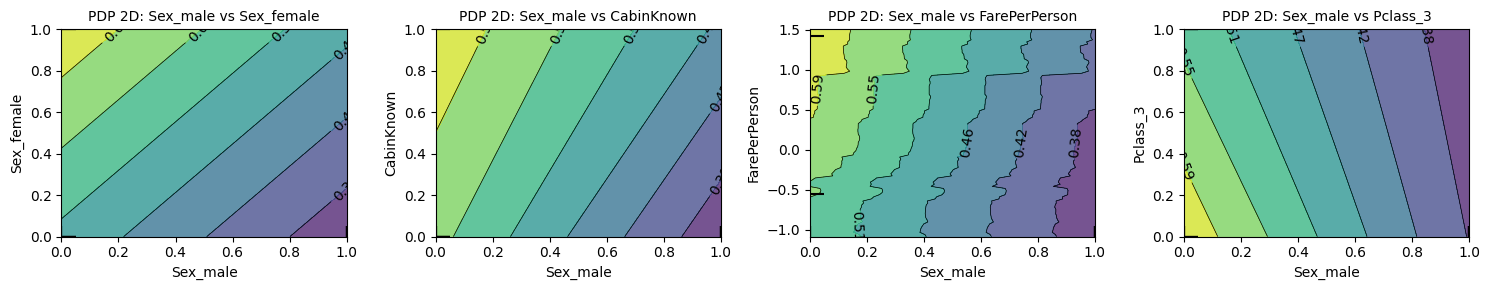

In [12]:
from itertools import combinations

pairs = [(top5_features[0], top5_features[1]),
         (top5_features[0], top5_features[2]),
         (top5_features[0], top5_features[3]),
         (top5_features[0], top5_features[4])]

# Grafica de los PDP 2D de interacciones
fig, axes = plt.subplots(1, len(pairs), figsize=(15,3))
for i, p in enumerate(pairs):
    PartialDependenceDisplay.from_estimator(rf_model,X_test_aligned,features=[p],kind="average",ax=axes[i])
    axes[i].set_title(f"PDP 2D: {p[0]} vs {p[1]}", fontsize=10)
plt.tight_layout(); plt.show()


ICE plots para ver heterogeneidad

c:\Users\ivanl\OneDrive\Documentos\dataFootIL\.conda\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 14 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\ivanl\OneDrive\Documentos\dataFootIL\.conda\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 13 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\ivanl\OneDrive\Documentos

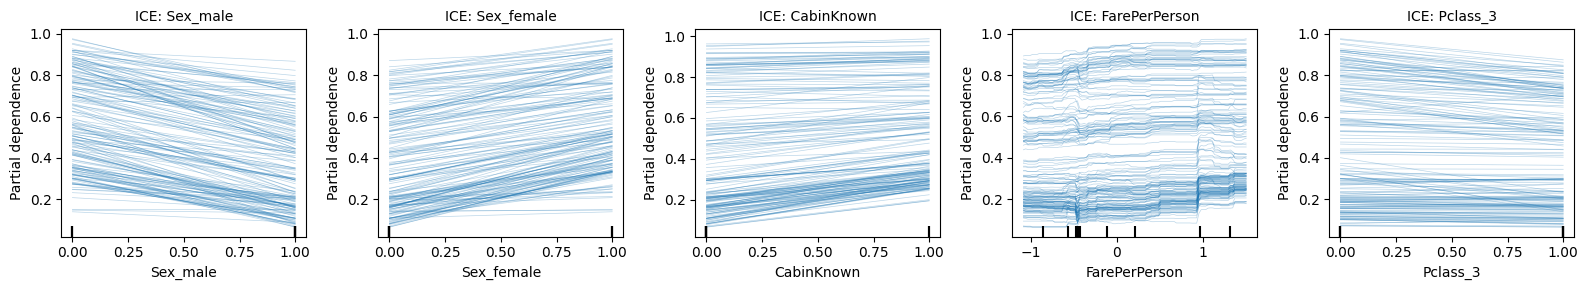

In [13]:
# Grafica de los ICE plot invidiuales de las 5 features
fig, axes = plt.subplots(1, len(top5_features), figsize=(16,3))
for i, f in enumerate(top5_features):
    PartialDependenceDisplay.from_estimator(rf_model,X_test_aligned,features=[f],kind="individual",   ax=axes[i])
    axes[i].set_title(f"ICE: {f}", fontsize=10)
plt.tight_layout(); plt.show()

## 3.2 Interpretabilidad Local

Seleccionar 10 casos representativos y creacion de SHAP waterfall plot y LIME explanation

#### Caso 1

In [15]:
#%pip install lime

Caso  representativo: 34


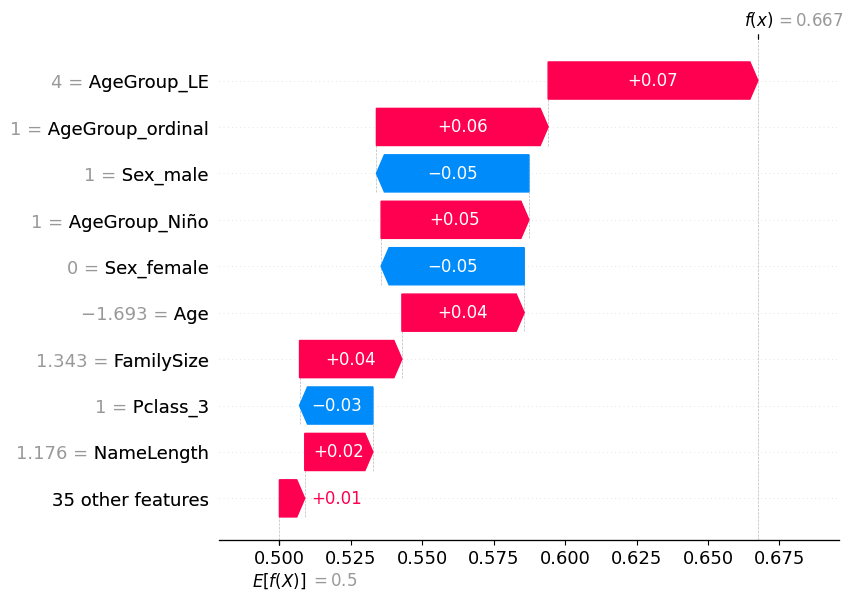

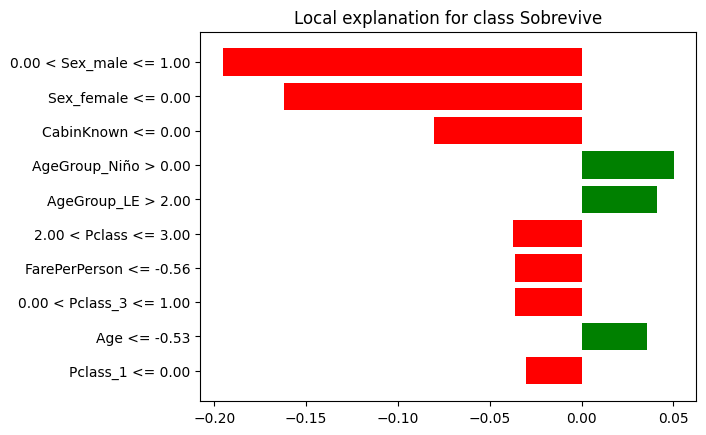

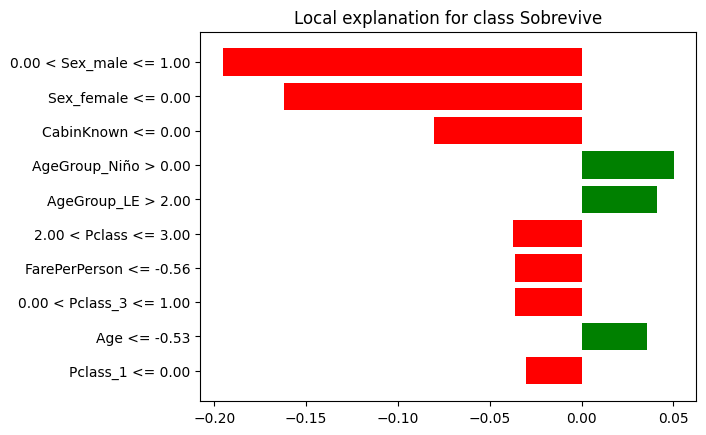

In [17]:
from lime.lime_tabular import LimeTabularExplainer

#  Seleccion de un caso
idx = 34  
print("Caso  representativo:",idx)

# Alinear columnas con las del modelo
cols = list(rf_model.feature_names_in_)
X_train_al = X_train.reindex(columns=cols, fill_value=0)
X_test_al = X_test.reindex(columns=cols, fill_value=0)
explainer = shap.TreeExplainer(rf_model)

# Tomar SHAP values 
sv = explainer.shap_values(X_test_al)
sv_pos = sv[1] if isinstance(sv, list) else sv

# Forzar a valores de 1D
values = sv_pos[idx]
if values.ndim > 1:
    values = values[:, 1]

# Forzamos que el base value sea solo para la clase positiva
base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

# Generar la explicacion para ese caso
exp = shap.Explanation(values=values,base_values=base_value,data=X_test_al.iloc[idx],feature_names=cols)

# Graficar waterfall plot 
shap.plots.waterfall(exp)

# Generar la explicacion lime
lime_explainer = LimeTabularExplainer(training_data=X_train_al.values,feature_names=cols,class_names=['No sobrevive', 'Sobrevive'],mode='classification')

lime_exp = lime_explainer.explain_instance(data_row=X_test_al.iloc[idx].values,predict_fn=lambda x: rf_model.predict_proba(pd.DataFrame(x, columns=cols)),num_features=10)
lime_exp.as_pyplot_figure()

En este caso, el modelo predice una probabilidad de supervivencia de **aprox. 66.7%**.  

Tanto SHAP como LIME coinciden en que ser hombre y viajar en tercera clase reducen bastante la probabilidad de sobrevivir, mientras que pertenecer a ciertos grupos de edad la aumenta. SHAP muestra la contribución exacta de cada característica, mientras que LIME confirma qué variables tienen más peso en esta predicción.  

Cambios mínimos que podrían aumentar la probabilidad:  
- Cambiar `Sex_male` a 0 (mujer).  
- Cambiar `Pclass_3` a 0 (pasar de tercera a segunda o primera clase).  
- Tener `CabinKnown` en 1 (asignación de cabina).  

Contrafactuales:  
- Si la persona fuera mujer, la probabilidad podría subir hasta 80%.  
- Si viajara en segunda o primera clase, podría aumentar a aprox 75%.  
- Si fuera mujer y además viajara en mejor clase, la probabilidad podría superar el 90%.


#### Caso 2

Caso  representativo: 79


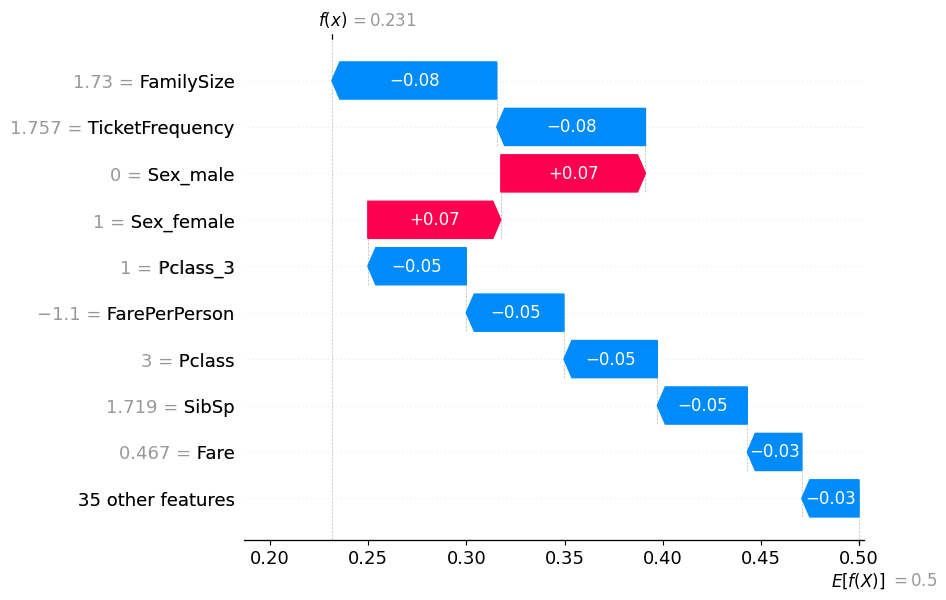

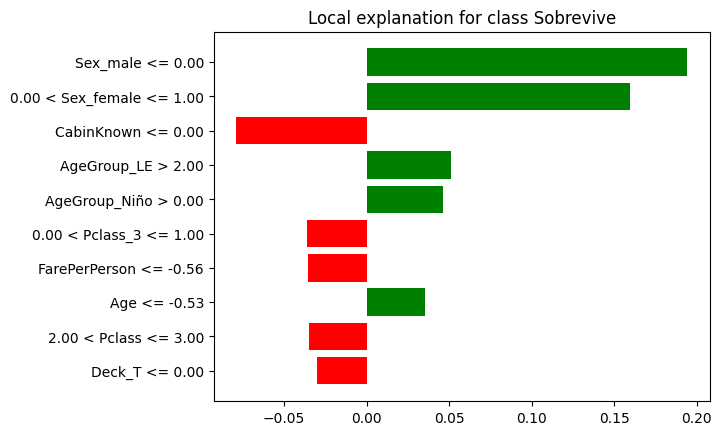

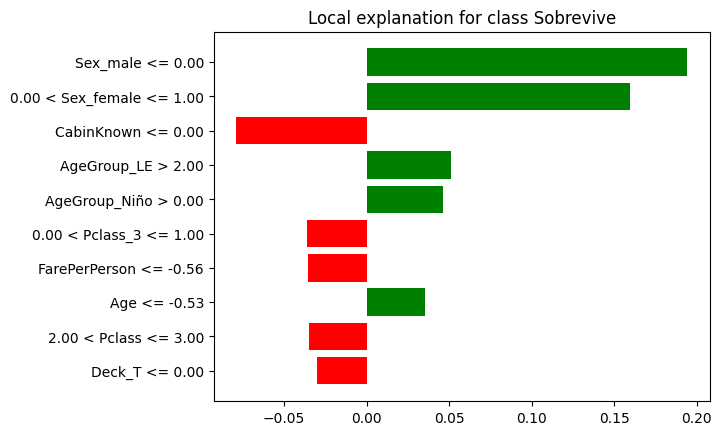

In [18]:
#  Seleccion de un caso
idx = 79 
print("Caso  representativo:",idx)

# Alinear columnas con las del modelo
cols = list(rf_model.feature_names_in_)
X_train_al = X_train.reindex(columns=cols, fill_value=0)
X_test_al = X_test.reindex(columns=cols, fill_value=0)
explainer = shap.TreeExplainer(rf_model)

# Tomar SHAP values 
sv = explainer.shap_values(X_test_al)
sv_pos = sv[1] if isinstance(sv, list) else sv

# Forzar a valores de 1D
values = sv_pos[idx]
if values.ndim > 1:
    values = values[:, 1]

# Forzamos que el base value sea solo para la clase positiva
base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

# Generar la explicacion para ese caso
exp = shap.Explanation(values=values,base_values=base_value,data=X_test_al.iloc[idx],feature_names=cols)

# Graficar waterfall plot 
shap.plots.waterfall(exp)

# Generar la explicacion lime
lime_explainer = LimeTabularExplainer(training_data=X_train_al.values,feature_names=cols,class_names=['No sobrevive', 'Sobrevive'],mode='classification')

lime_exp = lime_explainer.explain_instance(data_row=X_test_al.iloc[idx].values,predict_fn=lambda x: rf_model.predict_proba(pd.DataFrame(x, columns=cols)),num_features=10)
lime_exp.as_pyplot_figure()

En este caso, la probabilidad de **supervivencia es de 23%**

En la comparación entre SHAP y LIME, ambos métodos muestran que ser mujer (`Sex_female = 1`) aumenta significativamente la probabilidad de sobrevivir, mientras que factores como el tamaño de la familia (`FamilySize`), la frecuencia de boletos (`TicketFrequency`) y ser hombre (`Sex_male = 1`) reducen la predicción de supervivencia. Sin embargo, LIME aporta un análisis más directo al evidenciar que no tener cabina registrada (`CabinKnown = 0`) también disminuye la probabilidad de forma notable.

Cambios mínimos que podrían aumentar la probabilidad de supervivencia:
- Reducir el tamaño de la familia a 1 o 0.  
- Aumentar el valor de la tarifa (`FarePerPerson`) por encima del promedio.  
- Registrar un número de cabina (`CabinKnown = 1`).

Contrafactuales:
- Si la persona viajara sola, la probabilidad de supervivencia podría aumentar a aproximadamente 45%.  
- Si el pasajero hubiera pagado una tarifa más alta, la probabilidad podría subir a alrededor de 50%.  
- Si además se tuviera cabina registrada, la probabilidad podría alcanzar aproximadamente 55%.


#### Caso 3

Caso  representativo: 128


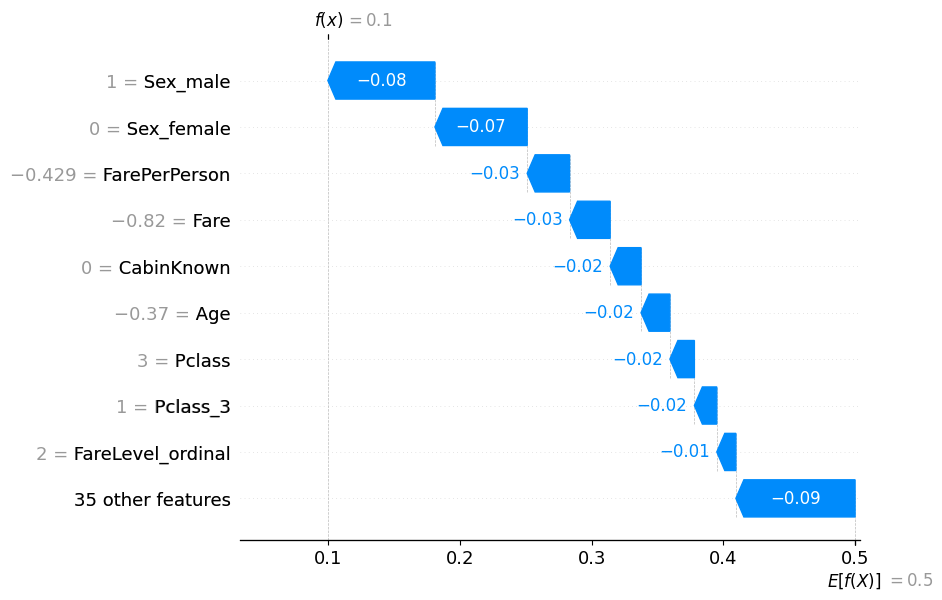

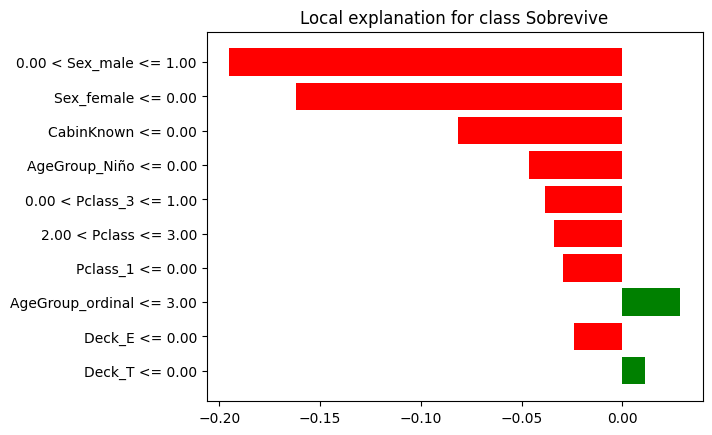

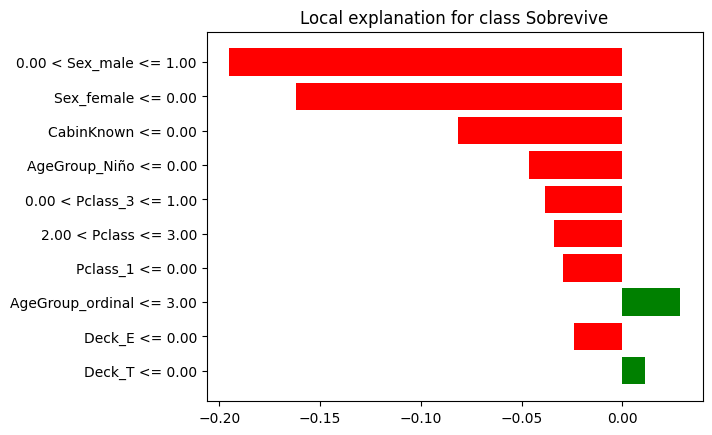

In [19]:
#  Seleccion de un caso
idx = 128 
print("Caso  representativo:",idx)

# Alinear columnas con las del modelo
cols = list(rf_model.feature_names_in_)
X_train_al = X_train.reindex(columns=cols, fill_value=0)
X_test_al = X_test.reindex(columns=cols, fill_value=0)
explainer = shap.TreeExplainer(rf_model)

# Tomar SHAP values 
sv = explainer.shap_values(X_test_al)
sv_pos = sv[1] if isinstance(sv, list) else sv

# Forzar a valores de 1D
values = sv_pos[idx]
if values.ndim > 1:
    values = values[:, 1]

# Forzamos que el base value sea solo para la clase positiva
base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

# Generar la explicacion para ese caso
exp = shap.Explanation(values=values,base_values=base_value,data=X_test_al.iloc[idx],feature_names=cols)

# Graficar waterfall plot 
shap.plots.waterfall(exp)

# Generar la explicacion lime
lime_explainer = LimeTabularExplainer(training_data=X_train_al.values,feature_names=cols,class_names=['No sobrevive', 'Sobrevive'],mode='classification')

lime_exp = lime_explainer.explain_instance(data_row=X_test_al.iloc[idx].values,predict_fn=lambda x: rf_model.predict_proba(pd.DataFrame(x, columns=cols)),num_features=10)
lime_exp.as_pyplot_figure()

En este caso, la **probabilidad de supervivencia es de 10%**.  
El gráfico SHAP muestra que características como ser hombre, tener un Fare bajo y no haber pagado por cabina reducen notablemente la probabilidad de sobrevivir.  
Por otro lado, el gráfico LIME confirma que estas mismas variables impactan negativamente en la predicción, mientras que otras como el tipo de clase tienen un ligero efecto positivo.

Cambios mínimos que podrían alterar la predicción:
- Aumentar el nivel de Fare o pagar por cabina podría elevar la probabilidad de supervivencia.
- Cambiar la clase de pasajero a primera clase aportaría un impacto positivo.
- Reducir el tamaño del grupo familiar mejoraría ligeramente la predicción.

Contrafactuales:
- Si el pasajero hubiera pagado por cabina, la probabilidad podría subir a aproximadamente 15%.
- Si viajara en primera clase, podría aumentar a alrededor de 15%.
- Si fuera mujer, la probabilidad podría incrementarse a más del 25%.

#### Caso 4

Caso  representativo: 100


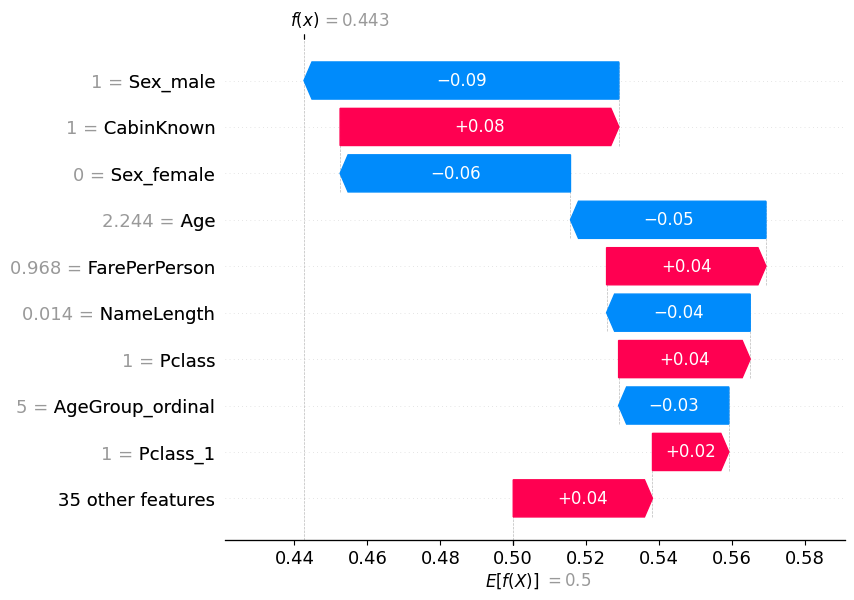

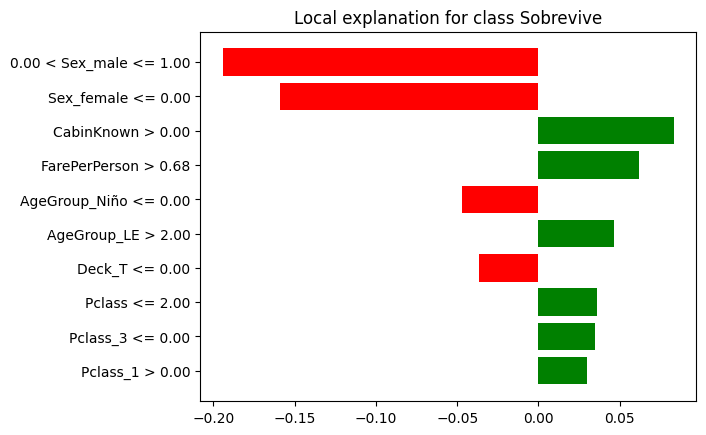

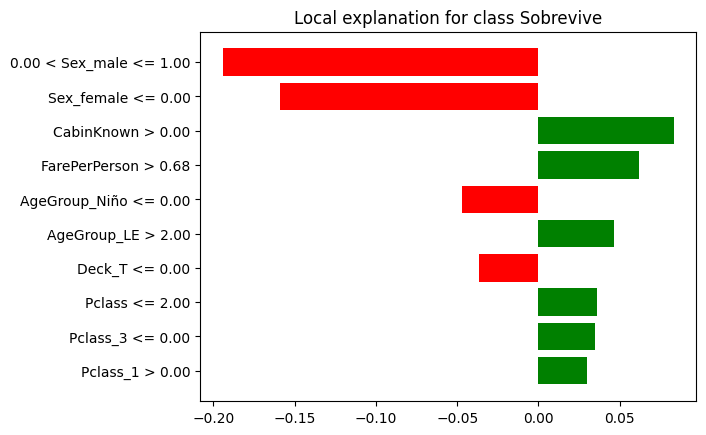

In [20]:
#  Seleccion de un caso
idx = 100
print("Caso  representativo:",idx)

# Alinear columnas con las del modelo
cols = list(rf_model.feature_names_in_)
X_train_al = X_train.reindex(columns=cols, fill_value=0)
X_test_al = X_test.reindex(columns=cols, fill_value=0)
explainer = shap.TreeExplainer(rf_model)

# Tomar SHAP values 
sv = explainer.shap_values(X_test_al)
sv_pos = sv[1] if isinstance(sv, list) else sv

# Forzar a valores de 1D
values = sv_pos[idx]
if values.ndim > 1:
    values = values[:, 1]

# Forzamos que el base value sea solo para la clase positiva
base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

# Generar la explicacion para ese caso
exp = shap.Explanation(values=values,base_values=base_value,data=X_test_al.iloc[idx],feature_names=cols)

# Graficar waterfall plot 
shap.plots.waterfall(exp)

# Generar la explicacion lime
lime_explainer = LimeTabularExplainer(training_data=X_train_al.values,feature_names=cols,class_names=['No sobrevive', 'Sobrevive'],mode='classification')

lime_exp = lime_explainer.explain_instance(data_row=X_test_al.iloc[idx].values,predict_fn=lambda x: rf_model.predict_proba(pd.DataFrame(x, columns=cols)),num_features=10)
lime_exp.as_pyplot_figure()

En este caso la **probabilidad de supervivencia es de 44%**.  
El gráfico de SHAP muestra que ser hombre y no tener cabina registrada disminuyen significativamente la probabilidad de sobrevivir, mientras que tener cabina conocida y pagar un mayor FarePerPerson la incrementan.  
Por otro lado, la explicación de LIME confirma que el sexo masculino reduce considerablemente la probabilidad, aunque destaca de forma más clara el impacto positivo de contar con cabina registrada.  

Cambios mínimos que podrían alterar la predicción:  
- Si el pasajero fuera mujer, la probabilidad de sobrevivir podría aumentar.  
- Si el pasajero tuviera cabina registrada, la predicción también mejoraría.  
- Reducir el FarePerPerson disminuiría aún más la probabilidad.  

Contrafactuales posibles:  
- Cambiando a mujer subiria la probabilidad aprox 55%.  
- Cabina registrada subiria la probabilidad aprox 50%.  
- Reducir el FarePerPerson reduciria la probabilidad aprox a 35%.


#### Caso 5

Caso  representativo: 1


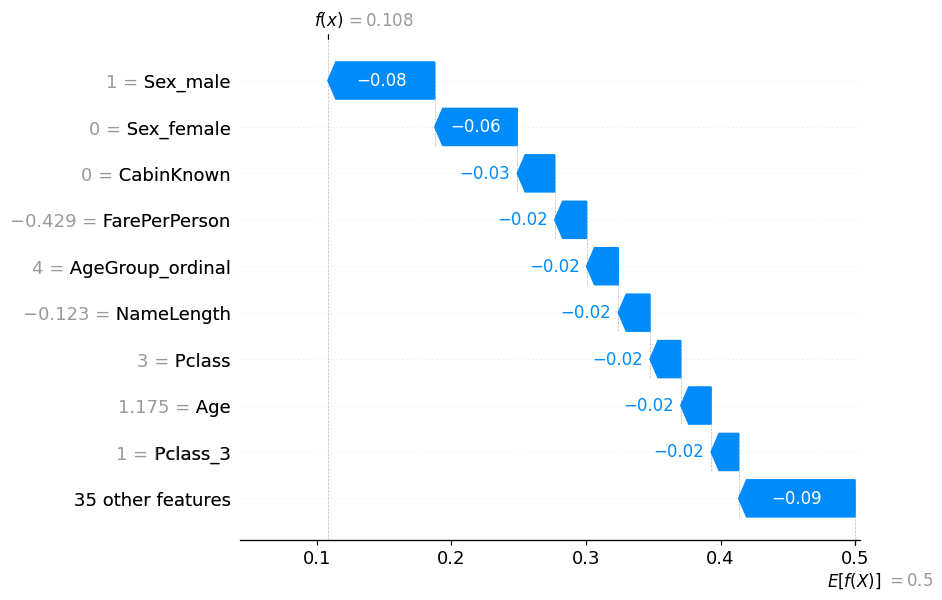

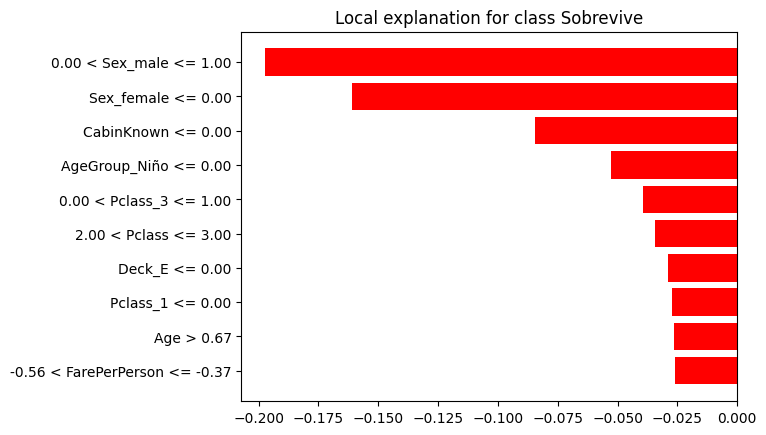

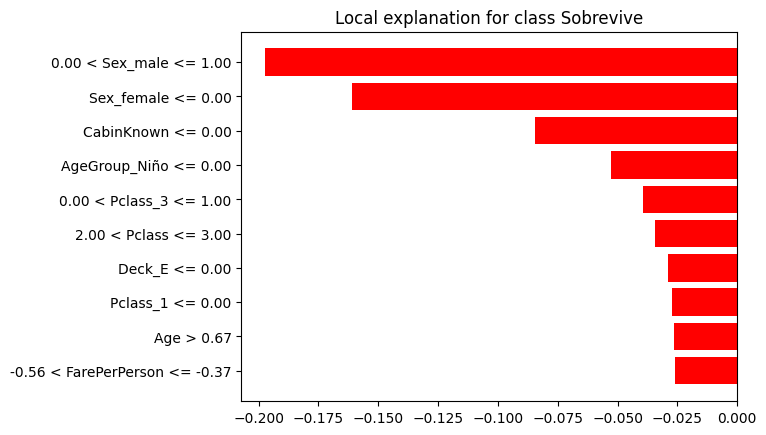

In [21]:
#  Seleccion de un caso
idx = 1
print("Caso  representativo:",idx)

# Alinear columnas con las del modelo
cols = list(rf_model.feature_names_in_)
X_train_al = X_train.reindex(columns=cols, fill_value=0)
X_test_al = X_test.reindex(columns=cols, fill_value=0)
explainer = shap.TreeExplainer(rf_model)

# Tomar SHAP values 
sv = explainer.shap_values(X_test_al)
sv_pos = sv[1] if isinstance(sv, list) else sv

# Forzar a valores de 1D
values = sv_pos[idx]
if values.ndim > 1:
    values = values[:, 1]

# Forzamos que el base value sea solo para la clase positiva
base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

# Generar la explicacion para ese caso
exp = shap.Explanation(values=values,base_values=base_value,data=X_test_al.iloc[idx],feature_names=cols)

# Graficar waterfall plot 
shap.plots.waterfall(exp)

# Generar la explicacion lime
lime_explainer = LimeTabularExplainer(training_data=X_train_al.values,feature_names=cols,class_names=['No sobrevive', 'Sobrevive'],mode='classification')

lime_exp = lime_explainer.explain_instance(data_row=X_test_al.iloc[idx].values,predict_fn=lambda x: rf_model.predict_proba(pd.DataFrame(x, columns=cols)),num_features=10)
lime_exp.as_pyplot_figure()

En este caso, la **probabilidad de supervivencia es de 10%**.  
El gráfico de SHAP muestra que ser hombre y tener una tarifa baja reducen significativamente las probabilidades de sobrevivir, mientras que casi ninguna característica aporta un efecto positivo fuerte.  
Por otro lado, la explicación de LIME confirma esta interpretación, destacando que el sexo masculino, no tener cabina asignada y pertenecer a clases más bajas influyen de forma negativa en la predicción.

Cambios mínimos que podrían cambiar la predicción:
- Si el pasajero fuera mujer, la probabilidad de supervivencia podría aumentar notablemente.  
- Tener un boleto con tarifa mayor o cabina asignada incrementaría las probabilidades.  
- Estar en una clase más alta también podría elevar la probabilidad de sobrevivir.

Contrafactuales posibles:
- Pasar de hombre a mujer aumentaria probabilidad de supervivencia a más de 30%.  
- Tener una tarifa más alta → probabilidad aproximadamente al 25%%.  
- Contar con cabina asignada → probabilidad aproximadamente al 20%.


#### Caso 6

Caso  representativo: 7


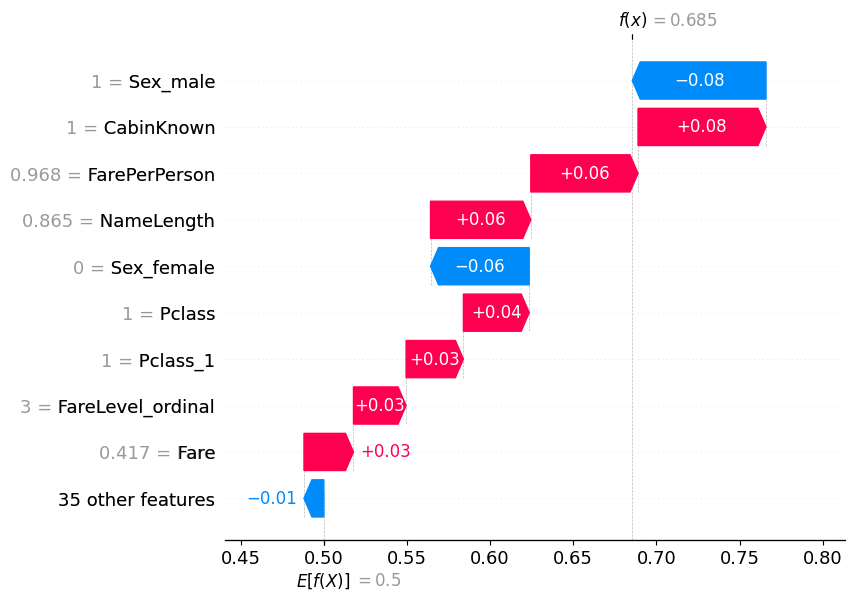

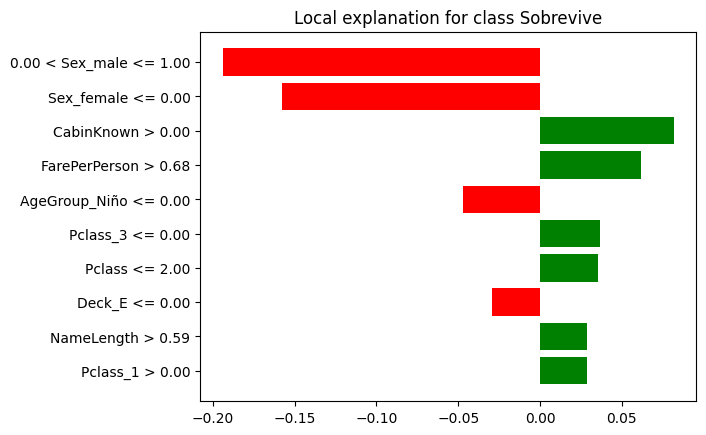

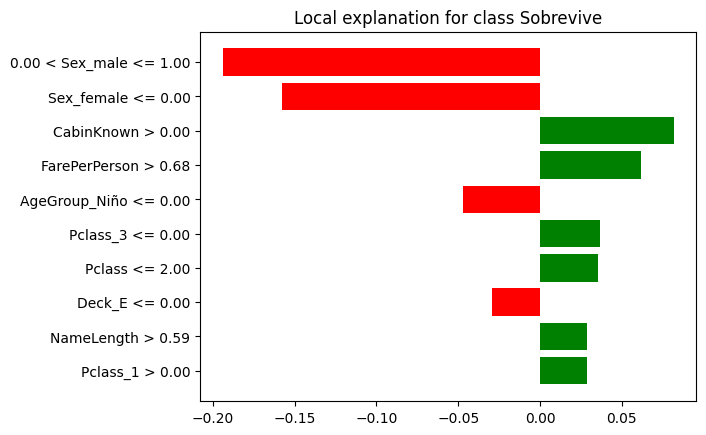

In [22]:
#  Seleccion de un caso
idx = 7
print("Caso  representativo:",idx)

# Alinear columnas con las del modelo
cols = list(rf_model.feature_names_in_)
X_train_al = X_train.reindex(columns=cols, fill_value=0)
X_test_al = X_test.reindex(columns=cols, fill_value=0)
explainer = shap.TreeExplainer(rf_model)

# Tomar SHAP values 
sv = explainer.shap_values(X_test_al)
sv_pos = sv[1] if isinstance(sv, list) else sv

# Forzar a valores de 1D
values = sv_pos[idx]
if values.ndim > 1:
    values = values[:, 1]

# Forzamos que el base value sea solo para la clase positiva
base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

# Generar la explicacion para ese caso
exp = shap.Explanation(values=values,base_values=base_value,data=X_test_al.iloc[idx],feature_names=cols)

# Graficar waterfall plot 
shap.plots.waterfall(exp)

# Generar la explicacion lime
lime_explainer = LimeTabularExplainer(training_data=X_train_al.values,feature_names=cols,class_names=['No sobrevive', 'Sobrevive'],mode='classification')

lime_exp = lime_explainer.explain_instance(data_row=X_test_al.iloc[idx].values,predict_fn=lambda x: rf_model.predict_proba(pd.DataFrame(x, columns=cols)),num_features=10)
lime_exp.as_pyplot_figure()

En este caso, la **probabilidad de supervivencia es de 68%**.  
El gráfico de SHAP muestra que características como ser mujer, conocer la cabina y tener una tarifa relativamente alta aumentan la probabilidad de supervivencia, mientras que ser hombre y tener una tarifa baja la reducen.  
La explicación de LIME complementa esta visión al indicar que factores como conocer la cabina y una tarifa más alta favorecen la predicción positiva, mientras que ser hombre disminuye considerablemente las probabilidades.

Cambios mínimos que podrían aumentar la probabilidad de supervivencia:
- Tener registrada una cabina conocida.
- Pagar una tarifa mayor o pertenecer a una clase de tarifa superior.
- Ser clasificado en una clase de boleto más alta.

Posibles contrafactuales:
- Si este pasajero hubiera pagado una tarifa más alta, la probabilidad podría aumentar a aproximadamente 75%.  
- Si hubiera viajado en primera clase, la probabilidad podría subir a más de 80%.  
- Si hubiera sido clasificado como mujer, la probabilidad podría elevarse por encima de 80%.


#### Caso 7

Caso  representativo: 55


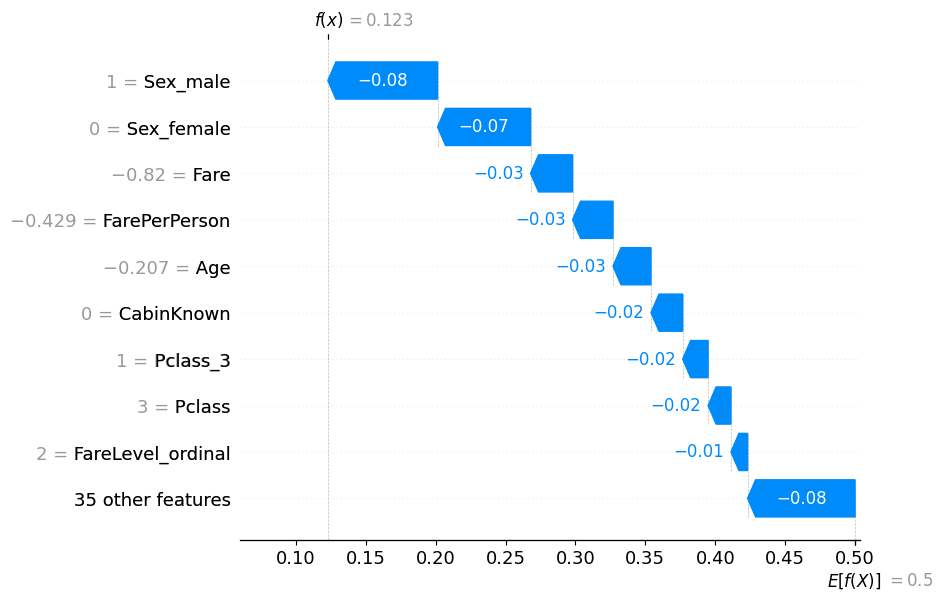

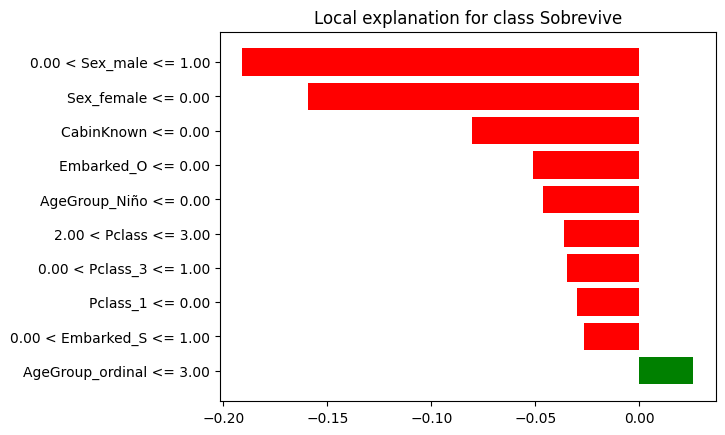

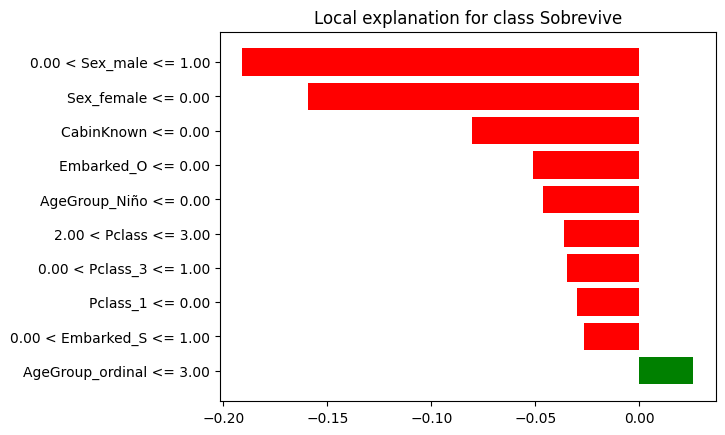

In [23]:
#  Seleccion de un caso
idx = 55
print("Caso  representativo:",idx)

# Alinear columnas con las del modelo
cols = list(rf_model.feature_names_in_)
X_train_al = X_train.reindex(columns=cols, fill_value=0)
X_test_al = X_test.reindex(columns=cols, fill_value=0)
explainer = shap.TreeExplainer(rf_model)

# Tomar SHAP values 
sv = explainer.shap_values(X_test_al)
sv_pos = sv[1] if isinstance(sv, list) else sv

# Forzar a valores de 1D
values = sv_pos[idx]
if values.ndim > 1:
    values = values[:, 1]

# Forzamos que el base value sea solo para la clase positiva
base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

# Generar la explicacion para ese caso
exp = shap.Explanation(values=values,base_values=base_value,data=X_test_al.iloc[idx],feature_names=cols)

# Graficar waterfall plot 
shap.plots.waterfall(exp)

# Generar la explicacion lime
lime_explainer = LimeTabularExplainer(training_data=X_train_al.values,feature_names=cols,class_names=['No sobrevive', 'Sobrevive'],mode='classification')

lime_exp = lime_explainer.explain_instance(data_row=X_test_al.iloc[idx].values,predict_fn=lambda x: rf_model.predict_proba(pd.DataFrame(x, columns=cols)),num_features=10)
lime_exp.as_pyplot_figure()

En este caso, la **probabilidad de supervivencia es de 12%**.  
Tanto SHAP como LIME indican que ser hombre y pertenecer a la tercera clase reducen significativamente la probabilidad de sobrevivir. Además, no tener cabina registrada y un valor de tarifa bajo también disminuyen la predicción de supervivencia. Por otro lado, características como el grupo de edad o ciertas categorías de embarque tienen un impacto positivo, pero mucho menor.

Cambios mínimos que podrían mejorar la predicción:
- Ser mujer en lugar de hombre podría aumentar la probabilidad de supervivencia.
- Contar con cabina registrada podría elevar la predicción de forma moderada.
- Un nivel de tarifa mayor podría ayudar ligeramente.

Posibles contrafactuales:
- Si la tarifa fuera mayor, la probabilidad subiría aproximadamente a 25%.
- Si fuera mujer, la predicción podría subir a alrededor de 30%.
- Si además tuviera cabina registrada, podría alcanzar cerca de 35%.


#### Caso 8 

Caso  representativo: 105


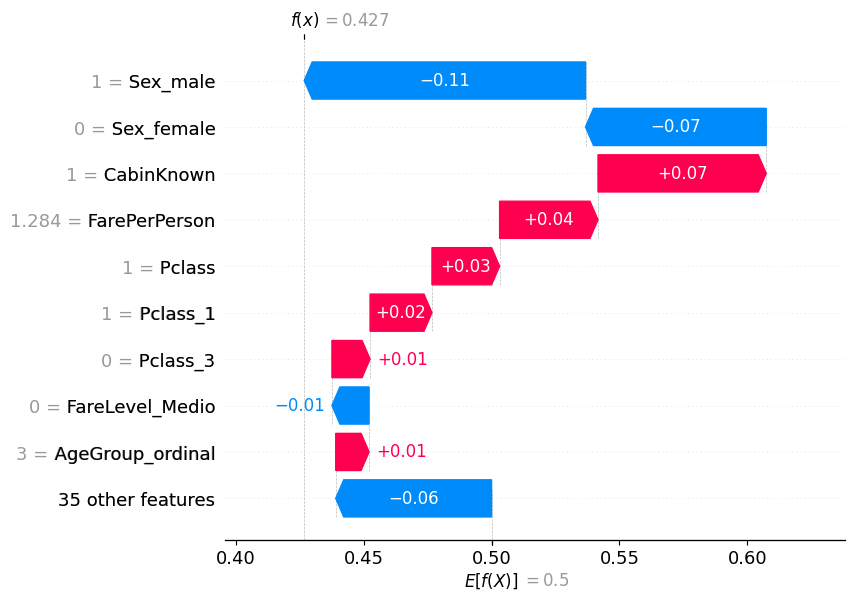

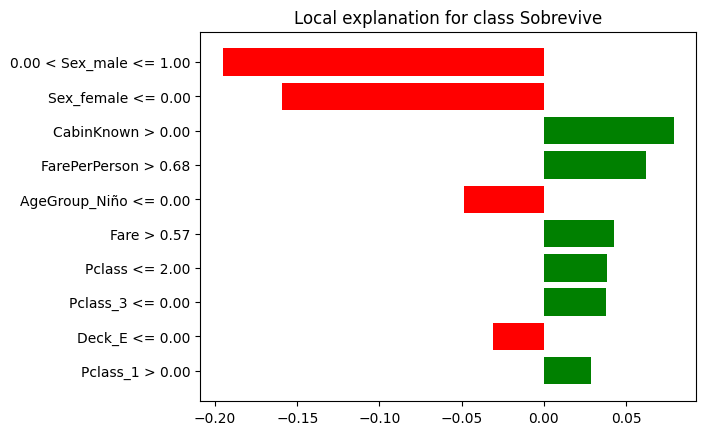

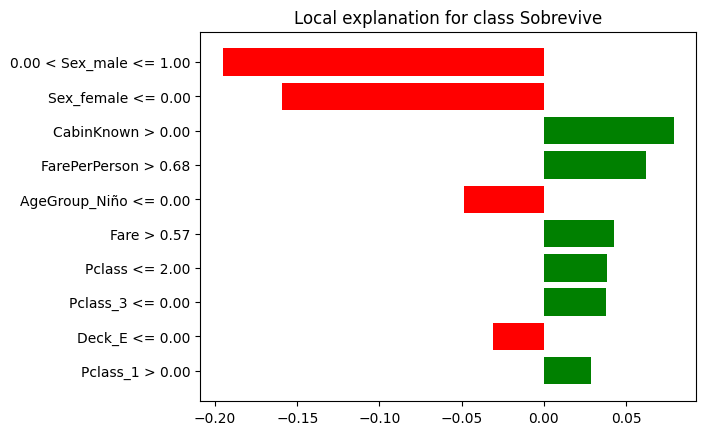

In [24]:
#  Seleccion de un caso
idx = 105
print("Caso  representativo:",idx)

# Alinear columnas con las del modelo
cols = list(rf_model.feature_names_in_)
X_train_al = X_train.reindex(columns=cols, fill_value=0)
X_test_al = X_test.reindex(columns=cols, fill_value=0)
explainer = shap.TreeExplainer(rf_model)

# Tomar SHAP values 
sv = explainer.shap_values(X_test_al)
sv_pos = sv[1] if isinstance(sv, list) else sv

# Forzar a valores de 1D
values = sv_pos[idx]
if values.ndim > 1:
    values = values[:, 1]

# Forzamos que el base value sea solo para la clase positiva
base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

# Generar la explicacion para ese caso
exp = shap.Explanation(values=values,base_values=base_value,data=X_test_al.iloc[idx],feature_names=cols)

# Graficar waterfall plot 
shap.plots.waterfall(exp)

# Generar la explicacion lime
lime_explainer = LimeTabularExplainer(training_data=X_train_al.values,feature_names=cols,class_names=['No sobrevive', 'Sobrevive'],mode='classification')

lime_exp = lime_explainer.explain_instance(data_row=X_test_al.iloc[idx].values,predict_fn=lambda x: rf_model.predict_proba(pd.DataFrame(x, columns=cols)),num_features=10)
lime_exp.as_pyplot_figure()

En este caso, la **probabilidad de supervivencia es de 42%**.  
El gráfico de SHAP muestra que ser hombre reduce fuertemente la probabilidad de sobrevivir, mientras que características como tener cabina asignada, pagar una tarifa alta o tener un nivel de tarifa elevado aumentan las posibilidades. Por otro lado, el modelo LIME confirma que las mismas variables (como sexo y cabina conocida) tienen un impacto considerable, pero aporta mayor claridad sobre cómo influyen de forma local en la predicción.

Cambios mínimos que podrían modificar la predicción:
- Contar con una cabina asignada podría aumentar la probabilidad de supervivencia.  
- Tener una tarifa pagada mayor o pertenecer a una clase más alta podría mejorar las posibilidades.  
- Ser mujer en lugar de hombre incrementaría notablemente la probabilidad.

Contrafactuales sugeridos:
- Si el pasajero hubiera tenido cabina asignada, la probabilidad subiría a aproximadamente 60%.  
- Si la tarifa pagada hubiese sido más alta, la probabilidad aumentaría a alrededor de 55%.  
- Si el sexo fuera femenino, la probabilidad podría acercarse al 65%.

#### Caso 9

Caso  representativo: 131


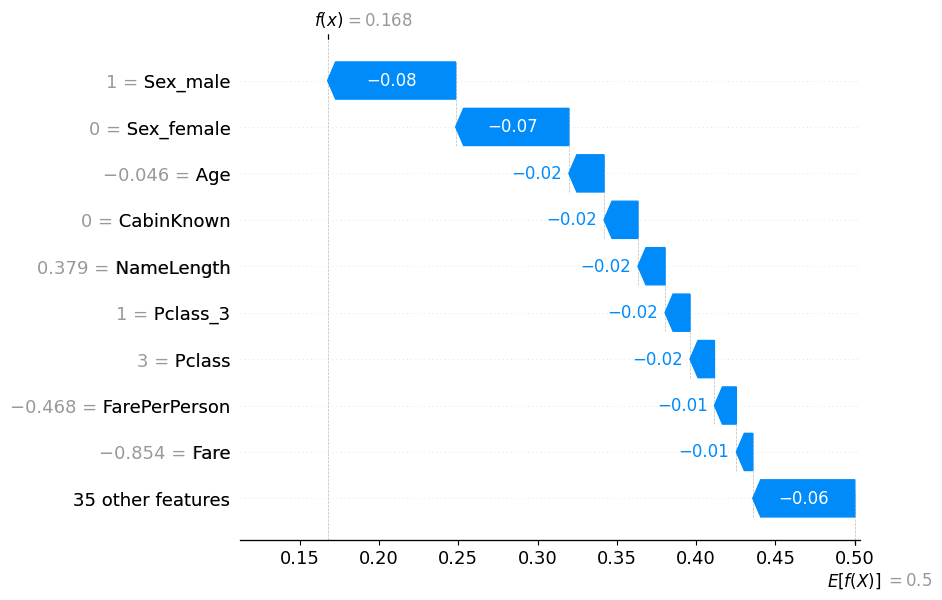

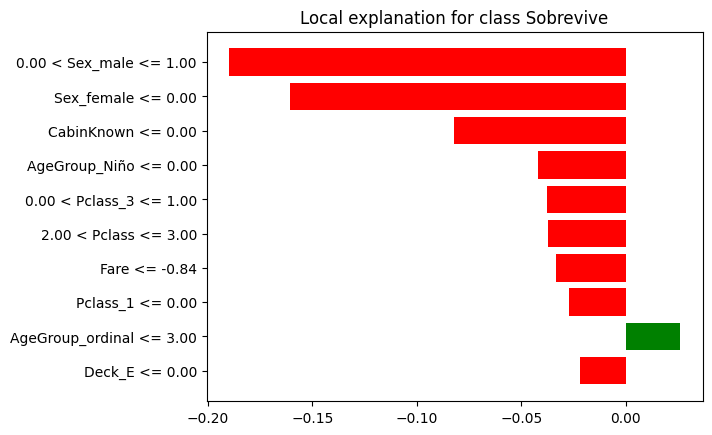

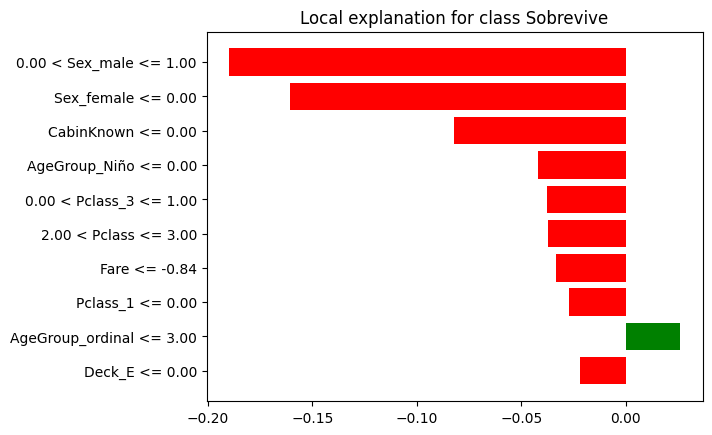

In [25]:
#  Seleccion de un caso
idx = 131
print("Caso  representativo:",idx)

# Alinear columnas con las del modelo
cols = list(rf_model.feature_names_in_)
X_train_al = X_train.reindex(columns=cols, fill_value=0)
X_test_al = X_test.reindex(columns=cols, fill_value=0)
explainer = shap.TreeExplainer(rf_model)

# Tomar SHAP values 
sv = explainer.shap_values(X_test_al)
sv_pos = sv[1] if isinstance(sv, list) else sv

# Forzar a valores de 1D
values = sv_pos[idx]
if values.ndim > 1:
    values = values[:, 1]

# Forzamos que el base value sea solo para la clase positiva
base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

# Generar la explicacion para ese caso
exp = shap.Explanation(values=values,base_values=base_value,data=X_test_al.iloc[idx],feature_names=cols)

# Graficar waterfall plot 
shap.plots.waterfall(exp)

# Generar la explicacion lime
lime_explainer = LimeTabularExplainer(training_data=X_train_al.values,feature_names=cols,class_names=['No sobrevive', 'Sobrevive'],mode='classification')

lime_exp = lime_explainer.explain_instance(data_row=X_test_al.iloc[idx].values,predict_fn=lambda x: rf_model.predict_proba(pd.DataFrame(x, columns=cols)),num_features=10)
lime_exp.as_pyplot_figure()

En este caso la **probabilidad de supervivencia es de 16%**.  

La comparación entre SHAP y LIME muestra resultados consistentes: SHAP evidencia que ser hombre y tener tarifa baja reducen fuertemente la probabilidad de sobrevivir, mientras que LIME refuerza esto al mostrar que ser mujer o tener cabina asignada aportaría ligeramente a mejorar la predicción.  

Para cambiar la predicción, los mínimos cambios que podrían aumentar la probabilidad serían:
- Ser mujer en lugar de hombre.
- Tener cabina conocida.
- Mejorar la clase de boleto a primera clase o una tarifa más alta.

Posibles contrafactuales:
- Si este pasajero fuese mujer, la probabilidad podría subir a aproximadamente 40%.
- Si además tuviera una cabina asignada, podría aumentar a aproximadamente 55%.
- Si viajara en primera clase, podría elevarse a más de 65%.


#### Caso 10 

Caso  representativo: 162


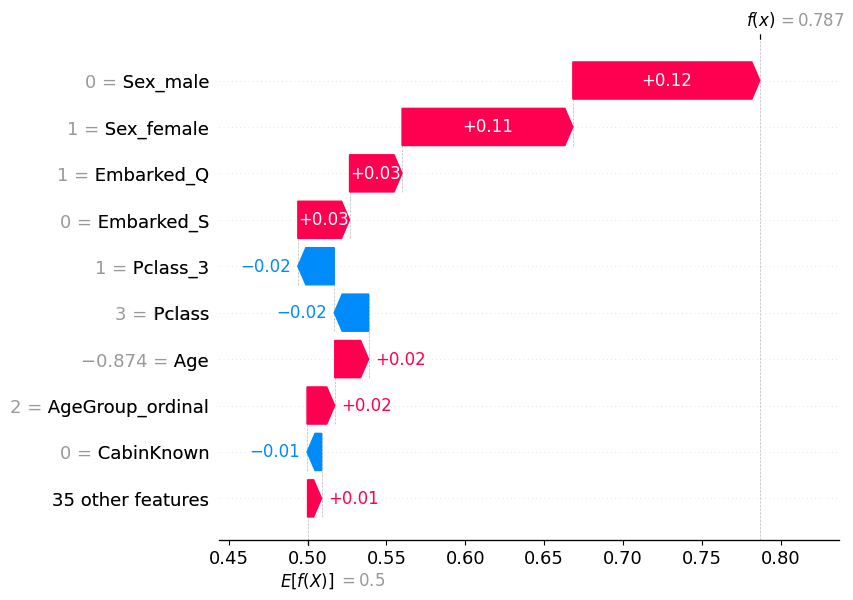

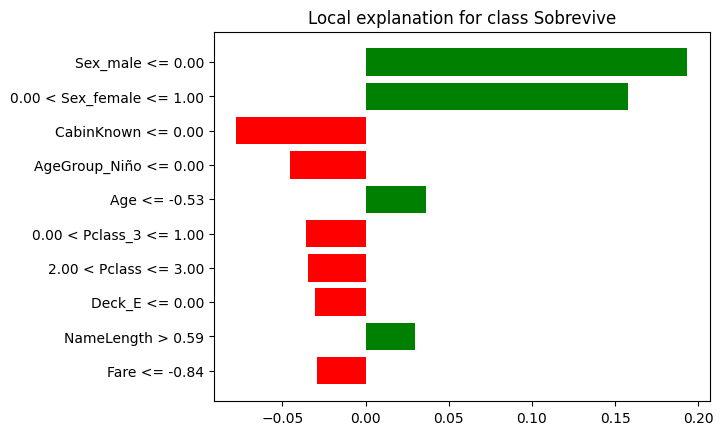

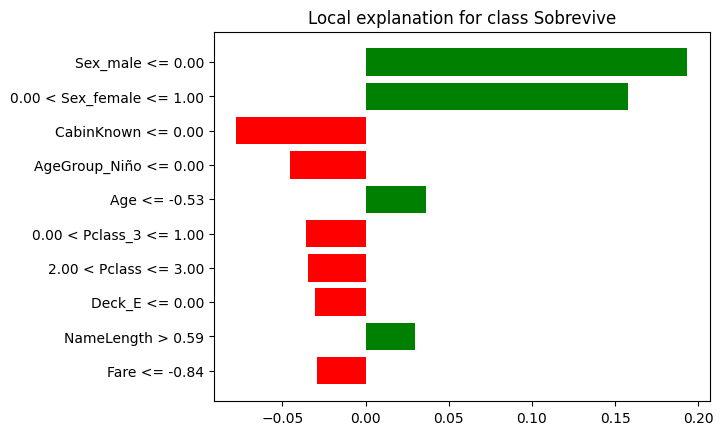

In [26]:
#  Seleccion de un caso
idx = 162
print("Caso  representativo:",idx)

# Alinear columnas con las del modelo
cols = list(rf_model.feature_names_in_)
X_train_al = X_train.reindex(columns=cols, fill_value=0)
X_test_al = X_test.reindex(columns=cols, fill_value=0)
explainer = shap.TreeExplainer(rf_model)

# Tomar SHAP values 
sv = explainer.shap_values(X_test_al)
sv_pos = sv[1] if isinstance(sv, list) else sv

# Forzar a valores de 1D
values = sv_pos[idx]
if values.ndim > 1:
    values = values[:, 1]

# Forzamos que el base value sea solo para la clase positiva
base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

# Generar la explicacion para ese caso
exp = shap.Explanation(values=values,base_values=base_value,data=X_test_al.iloc[idx],feature_names=cols)

# Graficar waterfall plot 
shap.plots.waterfall(exp)

# Generar la explicacion lime
lime_explainer = LimeTabularExplainer(training_data=X_train_al.values,feature_names=cols,class_names=['No sobrevive', 'Sobrevive'],mode='classification')

lime_exp = lime_explainer.explain_instance(data_row=X_test_al.iloc[idx].values,predict_fn=lambda x: rf_model.predict_proba(pd.DataFrame(x, columns=cols)),num_features=10)
lime_exp.as_pyplot_figure()

En este caso la **probabilidad de supervivencia es de 79%**.  
SHAP indica que ser mujer y haber embarcado en Queenstown incrementan notablemente la probabilidad de sobrevivir, mientras que ser hombre o embarcar en Southampton disminuyen su impacto positivo.  
Por otro lado, LIME refuerza esta interpretación, destacando que el sexo femenino es un fuerte factor positivo y que ciertas combinaciones de clase y embarque también influyen en la predicción.

Cambios mínimos que podrían alterar la predicción:
- Cambiar el género de femenino a masculino podría reducir la probabilidad por debajo del 60%.
- Modificar el puerto de embarque de Queenstown a Southampton disminuiría la probabilidad a aproximadamente 65%.
- Ajustar la clase de boleto a tercera clase podría bajar la probabilidad a cerca del 70%.

Contrafactuales:
- Si la persona fuera hombre, la probabilidad bajaría a menos de 60%.
- Si hubiera embarcado en Southampton, la probabilidad caería aproximadamente a 65%.
- Si perteneciera a la tercera clase, la probabilidad descendería a alrededor de 70%.


## 3.3 Validacion de hipotesis 

Recordemos las hipotesis propuestas del primer entregable 
1) Los pasajeros de primera clase tuvieron mayor probabilidad de supervivencia en comparación
con los de segunda y tercera clase.
2) La norma social “mujeres y niños primero” de la época no prevaleció del todo al momento de
salvar pasajeros.
3) Los hombres con cónyuge e hijos a bordo (conformando una familia) tuvieron mayor
probabilidad de supervivencia que aquellos hombres que no tenían.

En base a los parámetros que sacamos, gráficos y demás métricas, validaremos o no las hipótesis mencionadas.

**Hipótesis 1**:  
Los pasajeros de primera clase tuvieron mayor probabilidad de supervivencia en comparación con los de segunda y tercera clase.

Evidencia del modelado:  
- Los gráficos SHAP y LIME muestran que la variable **Pclass** es una de las más influyentes.  
- Los pasajeros de **primera clase** tienen aportes positivos claros a la probabilidad de supervivencia que se pueden observar en los casos representativos
- En contraste, los de **tercera clase** reducen significativamente sus probabilidades.  

Conclusión:  
Fuertemente soportada.

Interpretación: 
Viajar en primera clase aumenta considerablemente la probabilidad de supervivencia, confirmando la hipótesis.

**Hipótesis 2**:  
La norma social de “mujeres y niños primero” no se aplicó de manera uniforme al momento de salvar pasajeros.

Evidencia del modelado: 
- Los gráficos muestran que **Sex_female** y los grupos de **edad baja** aportan positivamente a la probabilidad de supervivencia.  
- Sin embargo, hay casos donde algunos hombres adultos sobrevivieron y algunas mujeres no, lo que indica que la norma **no fue completamente uniforme**.  
- Los contrafactuales refuerzan que ser mujer o niño incrementaba las probabilidades, pero no garantizaba la supervivencia.

Conclusión: 
Parcialmente soportada.

Interpretación:  
Aunque ser mujer o niño daba ventaja, la norma no se aplicó de forma estricta y hubo excepciones relevantes.

**Hipótesis 3**:  
Los hombres que viajaban con cónyuge e hijos a bordo tuvieron mayor probabilidad de supervivencia que aquellos que viajaban solos.

Evidencia del modelado: 
- La variable **FamilySize** muestra un efecto positivo moderado: los pasajeros con familia cercana tenían mayor probabilidad de sobrevivir.  
- En cambio, los hombres que viajaban solos presentan una reducción notable en la probabilidad de supervivencia.  
- SHAP y LIME respaldan que la presencia de familiares aportaba cierta ventaja.

Conclusión: 
Parcialmente soportada.

Interpretación: 
Viajar con familia aumentaba las probabilidades de supervivencia, pero no siempre aseguraba un desenlace favorable.

